## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.optimizers import SGD,Adam,RMSprop
from keras.callbacks import ReduceLROnPlateau
import itertools

#建立實驗的比較組合
optimizer_set = {'SGD':SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 'Adam':Adam(lr=LEARNING_RATE),
                 'RMSprop':RMSprop(lr=LEARNING_RATE)}
reduce_lr_factor = [0.8,0.5,0.3]
redice_lr_patient = [5,10,15]

In [9]:
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set.items(), reduce_lr_factor, redice_lr_patient)):
    
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i, optimizer: %s" % (i, reduce_factor, reduce_patient, optim[0]))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim[1])
    
    #設定 reduce learning rate 的 callback function
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("Factor(%s)Patience(%s)Optimizer(%s)" % (str(reduce_factor),str(reduce_patient),str(optim[0])))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.80, reduce_patient: 5, optimizer: SGD
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
___________________________________________________

50000/50000 [==============================] - 1s 30us/step - loss: 1.3454 - accuracy: 0.5310 - val_loss: 1.5177 - val_accuracy: 0.4621
Epoch 11/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.3190 - accuracy: 0.5400 - val_loss: 1.4981 - val_accuracy: 0.4717
Epoch 12/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.2916 - accuracy: 0.5523 - val_loss: 1.4976 - val_accuracy: 0.4765
Epoch 13/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.2694 - accuracy: 0.5599 - val_loss: 1.4911 - val_accuracy: 0.4736
Epoch 14/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.2450 - accuracy: 0.5679 - val_loss: 1.4805 - val_accuracy: 0.4808
Epoch 15/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.2227 - accuracy: 0.5762 - val_loss: 1.4741 - val_accuracy: 0.4818
Epoch 16/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.2022 - accuracy: 0.5836 - val_loss: 1.4720

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.2840 - accuracy: 0.2524 - val_loss: 2.1696 - val_accuracy: 0.1573
Epoch 2/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.7954 - accuracy: 0.3730 - val_loss: 2.0089 - val_accuracy: 0.2628
Epoch 3/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.6616 - accuracy: 0.4196 - val_loss: 1.8583 - val_accuracy: 0.3524
Epoch 4/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5844 - accuracy: 0.4458 - val_loss: 1.7378 - val_accuracy: 0.4018
Epoch 5/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.5274 - accuracy: 0.4662 - val_loss: 1.6626 - val_accuracy: 0.4257
Epoch 6/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4807 - accuracy: 0.4838 - val_loss: 1.6018 - val_accuracy: 0.4407
Epoch 7/25
50000/50000 [==============================] - 2s 31us/st

Epoch 21/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.1087 - accuracy: 0.6219 - val_loss: 1.4754 - val_accuracy: 0.4857
Epoch 22/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.0894 - accuracy: 0.6267 - val_loss: 1.4712 - val_accuracy: 0.4839
Epoch 23/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.0723 - accuracy: 0.6346 - val_loss: 1.4678 - val_accuracy: 0.4860
Epoch 24/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.0533 - accuracy: 0.6424 - val_loss: 1.4768 - val_accuracy: 0.4830
Epoch 25/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.0349 - accuracy: 0.6490 - val_loss: 1.4666 - val_accuracy: 0.4886
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 15, optimizer: SGD
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 

50000/50000 [==============================] - 2s 30us/step - loss: 1.5198 - accuracy: 0.4685 - val_loss: 1.6722 - val_accuracy: 0.4145
Epoch 6/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.4743 - accuracy: 0.4849 - val_loss: 1.6153 - val_accuracy: 0.4372
Epoch 7/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.4356 - accuracy: 0.4978 - val_loss: 1.5796 - val_accuracy: 0.4462
Epoch 8/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.4017 - accuracy: 0.5130 - val_loss: 1.5512 - val_accuracy: 0.4556
Epoch 9/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.3713 - accuracy: 0.5230 - val_loss: 1.5441 - val_accuracy: 0.4554
Epoch 10/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3412 - accuracy: 0.5354 - val_loss: 1.5227 - val_accuracy: 0.4647
Epoch 11/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3152 - accuracy: 0.5442 - val_loss: 1.5169 - v

50000/50000 [==============================] - 2s 30us/step - loss: 1.0106 - accuracy: 0.6587 - val_loss: 1.4576 - val_accuracy: 0.4927
Numbers of exp: 8, reduce_factor: 0.30, reduce_patient: 15, optimizer: SGD
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
______________________________________________

Epoch 10/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.9968 - accuracy: 0.6498 - val_loss: 2.1363 - val_accuracy: 0.3214
Epoch 11/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.9625 - accuracy: 0.6631 - val_loss: 1.9680 - val_accuracy: 0.3742

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 12/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.8970 - accuracy: 0.6857 - val_loss: 1.9091 - val_accuracy: 0.3962
Epoch 13/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.8465 - accuracy: 0.7061 - val_loss: 1.6830 - val_accuracy: 0.4363
Epoch 14/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.8077 - accuracy: 0.7197 - val_loss: 1.8148 - val_accuracy: 0.4157
Epoch 15/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.7824 - accuracy: 0.7272 - val_loss: 1.7753 - val_accuracy: 0.4210
Epoch 16/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.7710 - accuracy: 0.3796 - val_loss: 2.9554 - val_accuracy: 0.2005
Epoch 2/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5080 - accuracy: 0.4648 - val_loss: 1.8357 - val_accuracy: 0.3481
Epoch 3/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4178 - accuracy: 0.4979 - val_loss: 1.7773 - val_accuracy: 0.3750
Epoch 4/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3468 - accuracy: 0.5236 - val_loss: 1.5353 - val_accuracy: 0.4522
Epoch 5/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2879 - accuracy: 0.5464 - val_loss: 1.5727 - val_accuracy: 0.4396
Epoch 6/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2344 - accuracy: 0.5639 - val_loss: 1.5789 - val_accuracy: 0.4334
Epoch 7/25
50000/50000 [==============================] - 2s 31us/st

50000/50000 [==============================] - 2s 32us/step - loss: 0.7229 - accuracy: 0.7625 - val_loss: 1.4045 - val_accuracy: 0.5177
Epoch 20/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.7038 - accuracy: 0.7714 - val_loss: 1.3872 - val_accuracy: 0.5324
Epoch 21/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.6892 - accuracy: 0.7783 - val_loss: 1.4014 - val_accuracy: 0.5249
Epoch 22/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.6767 - accuracy: 0.7823 - val_loss: 1.4144 - val_accuracy: 0.5224
Epoch 23/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.6649 - accuracy: 0.7857 - val_loss: 1.4157 - val_accuracy: 0.5278

Epoch 00023: ReduceLROnPlateau reducing learning rate to 4.0960003389045596e-05.
Epoch 24/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.6409 - accuracy: 0.7987 - val_loss: 1.4046 - val_accuracy: 0.5330
Epoch 25/25
50000/50000 [=================

50000/50000 [==============================] - 2s 31us/step - loss: 1.4660 - accuracy: 0.4898 - val_loss: 1.7342 - val_accuracy: 0.4174
Epoch 4/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4011 - accuracy: 0.5097 - val_loss: 1.6751 - val_accuracy: 0.4175
Epoch 5/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3480 - accuracy: 0.5318 - val_loss: 1.5724 - val_accuracy: 0.4562
Epoch 6/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3024 - accuracy: 0.5468 - val_loss: 1.5190 - val_accuracy: 0.4697
Epoch 7/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2675 - accuracy: 0.5597 - val_loss: 1.4872 - val_accuracy: 0.4730
Epoch 8/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2331 - accuracy: 0.5753 - val_loss: 1.4911 - val_accuracy: 0.4739
Epoch 9/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2013 - accuracy: 0.5848 - val_loss: 1.4787 - val

50000/50000 [==============================] - 2s 31us/step - loss: 0.9163 - accuracy: 0.7012 - val_loss: 1.4049 - val_accuracy: 0.5083
Epoch 23/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.9120 - accuracy: 0.7022 - val_loss: 1.4136 - val_accuracy: 0.5058
Epoch 24/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.9038 - accuracy: 0.7067 - val_loss: 1.4066 - val_accuracy: 0.5070
Epoch 25/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.8986 - accuracy: 0.7082 - val_loss: 1.4121 - val_accuracy: 0.5114
Numbers of exp: 16, reduce_factor: 0.30, reduce_patient: 10, optimizer: Adam
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               157337

50000/50000 [==============================] - 2s 31us/step - loss: 1.4908 - accuracy: 0.4797 - val_loss: 1.6388 - val_accuracy: 0.4283
Epoch 7/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.4617 - accuracy: 0.4906 - val_loss: 1.5983 - val_accuracy: 0.4372
Epoch 8/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4371 - accuracy: 0.5006 - val_loss: 1.5792 - val_accuracy: 0.4453
Epoch 9/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4133 - accuracy: 0.5094 - val_loss: 1.5645 - val_accuracy: 0.4534
Epoch 10/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3920 - accuracy: 0.5161 - val_loss: 1.5451 - val_accuracy: 0.4514
Epoch 11/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3742 - accuracy: 0.5237 - val_loss: 1.5515 - val_accuracy: 0.4530
Epoch 12/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3570 - accuracy: 0.5284 - val_loss: 1.5433 - 

Epoch 25/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.5768 - accuracy: 0.8040 - val_loss: 1.8206 - val_accuracy: 0.4626

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
Numbers of exp: 19, reduce_factor: 0.80, reduce_patient: 10, optimizer: RMSprop
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_58 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normali

50000/50000 [==============================] - 2s 31us/step - loss: 1.1451 - accuracy: 0.6022 - val_loss: 1.7198 - val_accuracy: 0.4035
Epoch 9/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.1054 - accuracy: 0.6179 - val_loss: 2.0389 - val_accuracy: 0.3766
Epoch 10/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.0712 - accuracy: 0.6280 - val_loss: 1.8033 - val_accuracy: 0.4033
Epoch 11/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.0325 - accuracy: 0.6434 - val_loss: 1.9938 - val_accuracy: 0.3571
Epoch 12/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.0053 - accuracy: 0.6533 - val_loss: 1.7371 - val_accuracy: 0.4099
Epoch 13/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.9699 - accuracy: 0.6671 - val_loss: 1.7352 - val_accuracy: 0.4271
Epoch 14/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.9430 - accuracy: 0.6736 - val_loss: 1.7907 

Numbers of exp: 22, reduce_factor: 0.50, reduce_patient: 10, optimizer: RMSprop
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_67 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_68 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____________________________________________

50000/50000 [==============================] - 2s 31us/step - loss: 1.3140 - accuracy: 0.5458 - val_loss: 1.5418 - val_accuracy: 0.4657
Epoch 11/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2837 - accuracy: 0.5573 - val_loss: 1.5321 - val_accuracy: 0.4699
Epoch 12/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2569 - accuracy: 0.5656 - val_loss: 1.5149 - val_accuracy: 0.4654
Epoch 13/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.2315 - accuracy: 0.5765 - val_loss: 1.5194 - val_accuracy: 0.4685
Epoch 14/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.2066 - accuracy: 0.5867 - val_loss: 1.5138 - val_accuracy: 0.4723
Epoch 15/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.1839 - accuracy: 0.5959 - val_loss: 1.5039 - val_accuracy: 0.4764
Epoch 16/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.1605 - accuracy: 0.6050 - val_loss: 1.5176

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.4563 - accuracy: 0.2071 - val_loss: 2.2193 - val_accuracy: 0.1661
Epoch 2/25
50000/50000 [==============================] - 2s 31us/step - loss: 2.1060 - accuracy: 0.2886 - val_loss: 2.1210 - val_accuracy: 0.2327
Epoch 3/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.9501 - accuracy: 0.3299 - val_loss: 2.0129 - val_accuracy: 0.2951
Epoch 4/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.8520 - accuracy: 0.3581 - val_loss: 1.9241 - val_accuracy: 0.3265
Epoch 5/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.7827 - accuracy: 0.3803 - val_loss: 1.8415 - val_accuracy: 0.3517
Epoch 6/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.7292 - accuracy: 0.3987 - val_loss: 1.7852 - val_accuracy: 0.3754
Epoch 7/25
50000/50000 [==============================] - 2s 31us/st

Epoch 21/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.4062 - accuracy: 0.5154 - val_loss: 1.6025 - val_accuracy: 0.4403
Epoch 22/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.3931 - accuracy: 0.5185 - val_loss: 1.5999 - val_accuracy: 0.4421
Epoch 23/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3793 - accuracy: 0.5246 - val_loss: 1.5958 - val_accuracy: 0.4433
Epoch 24/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.3664 - accuracy: 0.5296 - val_loss: 1.5894 - val_accuracy: 0.4450
Epoch 25/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.3549 - accuracy: 0.5343 - val_loss: 1.5878 - val_accuracy: 0.4465


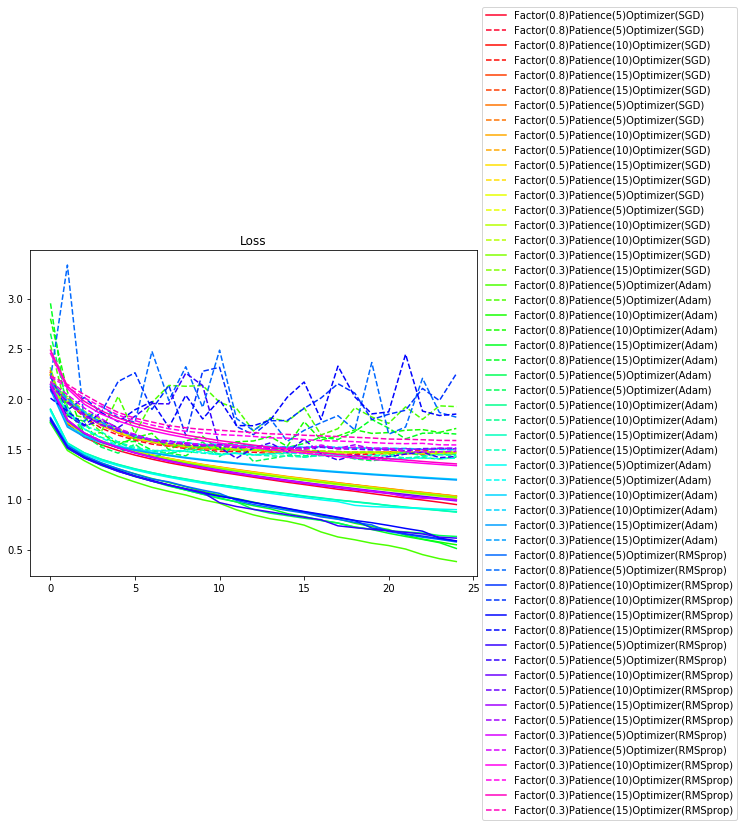

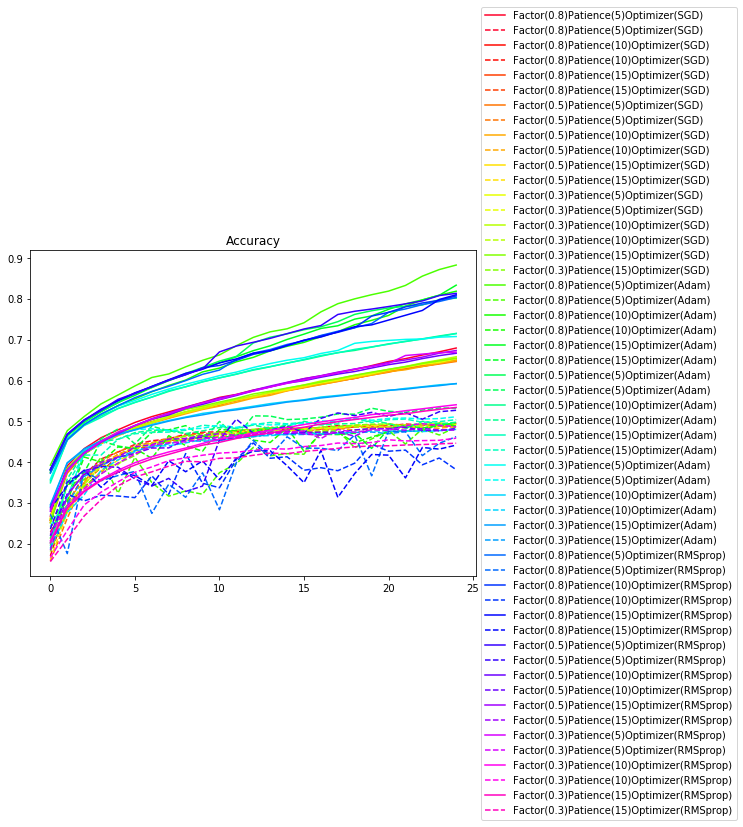

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)] 
#.to_rgba(i):Return a normalized rgba array corresponding to scalarMap.

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()